In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


Check GPU


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


Load CIFAR-10 Dataset (80/10/10 Split)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


Load dataset

In [4]:
dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)


Split (80/10/10 logic)

In [5]:
total_size = len(dataset)        # 50000
train_size = int(0.8 * total_size)
val_size   = int(0.1 * total_size)
test_size  = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)


DataLoaders

In [6]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)


Load Pretrained ResNet18 (CORE STEP)

In [7]:
model = torchvision.models.resnet18(pretrained=True)

model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)


# train only classifier
model.fc = nn.Linear(model.fc.in_features, 10)
for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loss Function & Optimizer

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)




Training Loop

In [9]:
train_acc, val_acc = [], []

epochs = 20

for epoch in range(epochs):
    model.train()
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100 * correct / total
    train_acc.append(train_accuracy)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_accuracy = 100 * correct / total
    val_acc.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Acc: {train_accuracy:.2f}% | "
          f"Val Acc: {val_accuracy:.2f}%")


Epoch [1/20] Train Acc: 62.04% | Val Acc: 73.90%
Epoch [2/20] Train Acc: 80.09% | Val Acc: 77.46%
Epoch [3/20] Train Acc: 87.39% | Val Acc: 77.88%
Epoch [4/20] Train Acc: 92.23% | Val Acc: 77.40%
Epoch [5/20] Train Acc: 95.28% | Val Acc: 78.00%
Epoch [6/20] Train Acc: 96.85% | Val Acc: 78.04%
Epoch [7/20] Train Acc: 97.36% | Val Acc: 78.16%
Epoch [8/20] Train Acc: 97.90% | Val Acc: 78.74%
Epoch [9/20] Train Acc: 98.15% | Val Acc: 77.60%
Epoch [10/20] Train Acc: 98.05% | Val Acc: 78.22%
Epoch [11/20] Train Acc: 98.33% | Val Acc: 78.80%
Epoch [12/20] Train Acc: 98.32% | Val Acc: 78.50%
Epoch [13/20] Train Acc: 98.42% | Val Acc: 78.78%
Epoch [14/20] Train Acc: 98.68% | Val Acc: 78.90%
Epoch [15/20] Train Acc: 98.80% | Val Acc: 78.78%
Epoch [16/20] Train Acc: 98.73% | Val Acc: 79.34%
Epoch [17/20] Train Acc: 98.78% | Val Acc: 78.92%
Epoch [18/20] Train Acc: 98.90% | Val Acc: 79.30%
Epoch [19/20] Train Acc: 98.94% | Val Acc: 79.68%
Epoch [20/20] Train Acc: 98.92% | Val Acc: 79.44%


Plot Accuracy Curves

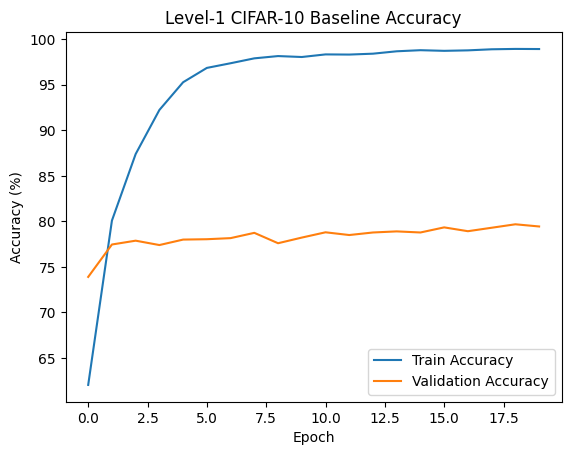

In [10]:
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Level-1 CIFAR-10 Baseline Accuracy")
plt.show()


Final Test Accuracy

In [11]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")


Final Test Accuracy: 80.86%
